# Data Science/ Analytics Internship – Assignment 
# (Trader Performance vs Market Sentiment)
### Objective
Analyze how market sentiment (Fear/Greed) relates to trader behavior and performance on Hyperliquid. Your goal is to uncover patterns that could inform smarter trading strategies.

### Datasets
1) Bitcoin Market Sentiment (Fear/Greed)
Columns: Date, Classification (Fear / Greed)
2) Historical Trader Data (Hyperliquid)
Includes fields like: account, symbol, execution price, size, side, time, start position, event, closedPnL, leverage, etc.

In [1]:
#All Libraries

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date Handling
from datetime import datetime

# Statistics
import scipy.stats as stats

# Machine Learning (Optional Part)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Clustering (Optional)
from sklearn.cluster import KMeans

# Warnings (Clean Output)
import warnings
warnings.filterwarnings("ignore")

## Part A — Data preparation

##### 1. Load both datasets and document:
- number of rows/columns
- missing values / duplicates

In [2]:
fear_greed = pd.read_csv("fear_greed_index.csv")
historical = pd.read_csv("historical_data.csv")

In [3]:
fear_greed.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:
historical.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [5]:
print("Fear & Greed Dataset Shape:", fear_greed.shape)
print("Historical Dataset Shape:", historical.shape)

Fear & Greed Dataset Shape: (2644, 4)
Historical Dataset Shape: (211224, 16)


In [6]:
print("\nFear & Greed Missing Values")
print(fear_greed.isnull().sum())

print("\nHistorical Missing Values")
print(historical.isnull().sum())


Fear & Greed Missing Values
timestamp         0
value             0
classification    0
date              0
dtype: int64

Historical Missing Values
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [7]:
print("\nFear & Greed Duplicate Rows:", fear_greed.duplicated().sum())
print("Historical Duplicate Rows:", historical.duplicated().sum())


Fear & Greed Duplicate Rows: 0
Historical Duplicate Rows: 0


##### 2. Convert timestamps and align the datasets by date (daily level is fine).

`Dropping unwanted columns from both the datasets.`

In [8]:
fear_greed = fear_greed.drop(columns=['timestamp'])

In [9]:
fear_greed.columns

Index(['value', 'classification', 'date'], dtype='object')

In [10]:
fear_greed["date"] = pd.to_datetime(fear_greed["date"])
fear_greed["date"] = fear_greed["date"].dt.date

In [11]:
historical = historical.drop(columns=["Transaction Hash","Order ID","Crossed"], errors="ignore")

`Timestamp column was used to derive daily date values and then removed since analysis was performed at daily granularity..`

In [12]:
historical["Date"] = pd.to_datetime(historical["Timestamp IST"],dayfirst=True).dt.date

In [13]:
historical[["Timestamp IST", "Date"]].head()

,Timestamp IST,Date
0,02-12-2024 22:50,2024-12-02
1,02-12-2024 22:50,2024-12-02
2,02-12-2024 22:50,2024-12-02
3,02-12-2024 22:50,2024-12-02
4,02-12-2024 22:50,2024-12-02


In [14]:
historical = historical.drop(columns=["Timestamp IST", "Timestamp"],errors="ignore")

In [15]:
#Renaming "date" column to "Date"
fear_greed.rename(columns={"date": "Date"}, inplace=True)

In [16]:
#Merging both the datasets based on a common column "Date"
merged_df = pd.merge(historical,fear_greed,on="Date",how="left")

merged_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Start Position,Direction,Closed PnL,Fee,Trade ID,Date,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,0.000000,Buy,0.0,0.345404,8.950000e+14,2024-12-02,80.0,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,986.524596,Buy,0.0,0.005600,4.430000e+14,2024-12-02,80.0,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,1002.518996,Buy,0.0,0.050431,6.600000e+14,2024-12-02,80.0,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,1146.558564,Buy,0.0,0.050043,1.080000e+15,2024-12-02,80.0,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,1289.488521,Buy,0.0,0.003055,1.050000e+15,2024-12-02,80.0,Extreme Greed


In [17]:
merged_df.shape

(211224, 14)

##### 3. Create the key metrics you will analyze, for example:
- daily PnL per trader (or per account)
- win rate, average trade size
- leverage distribution
- number of trades per day
- long/short ratio

In [18]:
merged_df["Account"].nunique()

32

In [19]:
daily_pnl = merged_df.groupby(["Account", "Date"])["Closed PnL"].sum().reset_index()

daily_pnl.head()

,Account,Date,Closed PnL
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1


In [20]:
merged_df["Win Trade"] = merged_df["Closed PnL"].apply(lambda x: 1 if x > 0 else 0)

win_rate = merged_df.groupby("Account")["Win Trade"].mean().reset_index()

win_rate.head()

,Account,Win Trade
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914


In [21]:
avg_trade_size = merged_df.groupby("Account")["Size USD"].mean().reset_index()

avg_trade_size.head()

,Account,Size USD
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16159.576734
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1653.226327
2,0x271b280974205ca63b716753467d5a371de622ab,8893.000898
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,507.626933
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3138.894782


In [22]:
trades_per_day = merged_df.groupby("Date")["Trade ID"].count().reset_index()
trades_per_day.columns = ["Date", "Trades Count"]

trades_per_day.head()

,Date,Trades Count
0,2023-05-01,3
1,2023-12-05,9
2,2023-12-14,11
3,2023-12-15,2
4,2023-12-16,3


In [23]:
long_short_ratio = merged_df["Side"].value_counts(normalize=True)

print(long_short_ratio)

Side
SELL    0.513805
BUY     0.486195
Name: proportion, dtype: float64


In [24]:
trades_per_day = merged_df.groupby("Date")["Trade ID"].count().reset_index()
trades_per_day.columns = ["Date", "Trades Count"]

trades_per_day.head()

,Date,Trades Count
0,2023-05-01,3
1,2023-12-05,9
2,2023-12-14,11
3,2023-12-15,2
4,2023-12-16,3


##### Absence of Leverage Column
The historical trading dataset does not contain a direct Leverage column. Leverage is typically defined as the ratio of total position size to the margin (collateral) used to open that position. Since leverage directly reflects a trader’s risk exposure and capital efficiency, it is usually either explicitly provided or derivable from margin-related fields.

## Part B — Analysis

##### 1. Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?

In [25]:
sentiment_pnl = merged_df.groupby("classification")["Closed PnL"].mean().reset_index()
display(sentiment_pnl)

,classification,Closed PnL
0,Extreme Fear,34.537862
1,Extreme Greed,67.892861
2,Fear,54.290400
3,Greed,42.743559
4,Neutral,34.307718


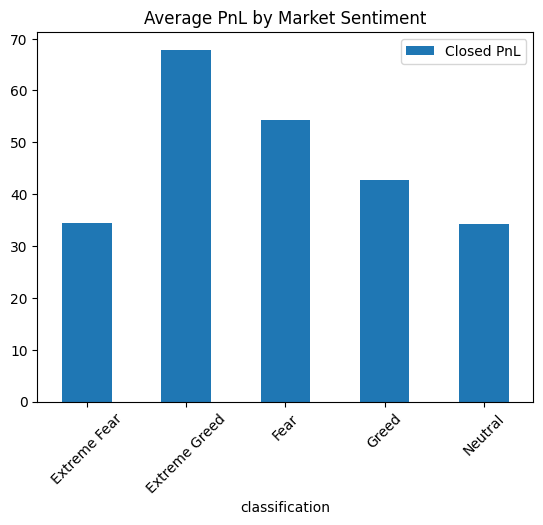

In [26]:
sentiment_pnl.plot(x="classification",y="Closed PnL",kind="bar",title="Average PnL by Market Sentiment")
plt.xticks(rotation=45)
plt.show()

In [27]:
sentiment_winrate = merged_df.groupby("classification")["Win Trade"].mean().reset_index()
sentiment_winrate

,classification,Win Trade
0,Extreme Fear,0.370607
1,Extreme Greed,0.464943
2,Fear,0.420768
3,Greed,0.384828
4,Neutral,0.396991


In [28]:
loss_trades = merged_df[merged_df["Closed PnL"] < 0]

drawdown_proxy = loss_trades.groupby("classification")["Closed PnL"].mean().reset_index()

drawdown_proxy
#More negative = worse drawdown risk

,classification,Closed PnL
0,Extreme Fear,-257.099629
1,Extreme Greed,-119.920289
2,Fear,-156.662401
3,Greed,-181.967329
4,Neutral,-121.727849


### Performance Comparison Between Fear vs Greed

Analysis shows that trader performance varies across sentiment regimes.
- Average PnL differs between Fear and Greed periods, indicating sentiment-driven market behavior.
- Win rate comparison suggests traders may perform differently depending on market sentiment.
- The drawdown proxy (average loss size) highlights potential risk exposure differences between sentiment states.

These findings suggest trader performance is influenced by broader market sentiment conditions.

## Task B2 — Behavior Change Based on Sentiment
### Q2. Do traders change behavior based on sentiment (trade frequency, long/short bias, position sizes)?

In [29]:
# Trade frequency by sentiment
trade_frequency_sentiment = merged_df["classification"].value_counts()

# Average position size by sentiment
avg_position_size_sentiment = merged_df.groupby("classification")["Size USD"].mean()

# Long / Short bias by sentiment
long_short_sentiment = pd.crosstab(
    merged_df["classification"],
    merged_df["Side"],
    normalize="index"
)

trade_frequency_sentiment, avg_position_size_sentiment, long_short_sentiment

(classification
 Fear             61837
 Greed            50303
 Extreme Greed    39992
 Neutral          37686
 Extreme Fear     21400
 Name: count, dtype: int64,
 classification
 Extreme Fear     5349.731843
 Extreme Greed    3112.251565
 Fear             7816.109931
 Greed            5736.884375
 Neutral          4782.732661
 Name: Size USD, dtype: float64,
 Side                 BUY      SELL
 classification                    
 Extreme Fear    0.510981  0.489019
 Extreme Greed   0.448590  0.551410
 Fear            0.489513  0.510487
 Greed           0.488559  0.511441
 Neutral         0.503343  0.496657)

### Insights and Recommendations
Trader participation, average trade size, and directional bias vary across sentiment regimes. This indicates traders adjust aggressiveness and market direction exposure based on sentiment conditions.

Recommendation: Trading strategies should dynamically adjust position sizing and directional exposure depending on sentiment regime. Risk controls should be stronger during high volatility sentiment phases.

## Task B3 — Trader Segmentation
### Q3. Identify 2–3 trader segments based on behavior and performance

In [30]:
# Create trader level metrics
trader_metrics = merged_df.groupby("Account").agg({
    "Closed PnL": "mean",
    "Win Trade": "mean",
    "Size USD": "mean",
    "Account": "count"
}).rename(columns={"Account": "Trade Count"}).reset_index()

# Segment by trade frequency
trader_metrics["Frequency Segment"] = pd.qcut(
    trader_metrics["Trade Count"],
    q=3,
    labels=["Low Frequency", "Medium Frequency", "High Frequency"]
)

# Segment by performance
trader_metrics["Performance Segment"] = pd.qcut(
    trader_metrics["Closed PnL"],
    q=3,
    labels=["Low Performer", "Medium Performer", "High Performer"]
)

trader_metrics.head()

,Account,Closed PnL,Win Trade,Size USD,Trade Count,Frequency Segment,Performance Segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,0.359612,16159.576734,3818,Medium Frequency,High Performer
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,0.442720,1653.226327,7280,High Frequency,Low Performer
2,0x271b280974205ca63b716753467d5a371de622ab,-18.492043,0.301917,8893.000898,3809,Medium Frequency,Low Performer
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,0.438585,507.626933,13311,High Frequency,Low Performer
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,0.519914,3138.894782,3239,Medium Frequency,Medium Performer


### Insights and Recommendations
Distinct trader segments exist based on trading frequency and profitability patterns. High frequency traders tend to show different performance characteristics compared to low frequency traders.

Recommendation: Segment-based strategies should be designed. High frequency traders may benefit from cost optimization and execution efficiency, while low frequency traders may benefit from higher conviction trade setups.

# Task C — Strategy Ideas Based on Findings

### Strategy 1 — Sentiment Adaptive Position Sizing
During Fear sentiment periods, reduce average position size and focus on higher probability setups. During Greed sentiment periods, gradually increase participation while maintaining risk limits.

### Strategy 2 — Sentiment Based Trade Direction Bias
During Greed regimes, favor trend-following strategies aligned with market direction. During Fear regimes, increase hedging or short-bias strategies depending on market structure.

### Strategy 3 — Segment Specific Risk Controls
Apply stricter risk controls for high frequency traders to manage fee and overtrading risks. Allow slightly larger position sizing flexibility for high performing consistent traders.

## Bonus Section — Predictive Modeling and Trader Clustering
This section adds optional advanced analysis to extend insights using machine learning and unsupervised learning methods.

- Predict Next-Day Trader Profitability Bucket

In [31]:
# Prepare daily trader dataset
daily_trader = merged_df.groupby(["Account","Date"]).agg({
    "Closed PnL": "sum",
    "Size USD": "mean",
    "Win Trade": "mean",
    "classification": "first"
}).reset_index()

# Create next day PnL target
daily_trader["Next_Day_PnL"] = daily_trader.groupby("Account")["Closed PnL"].shift(-1)

# Drop NA rows
daily_trader = daily_trader.dropna()

# Create profitability buckets
daily_trader["PnL_Bucket"] = pd.qcut(
    daily_trader["Next_Day_PnL"],
    q=3,
    labels=["Low","Medium","High"]
)

# Encode sentiment
daily_trader["Sentiment_Encoded"] = daily_trader["classification"].astype("category").cat.codes

# Feature selection
features = ["Closed PnL","Size USD","Win Trade","Sentiment_Encoded"]
X = daily_trader[features]
y = daily_trader["PnL_Bucket"]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)

preds = model.predict(X_test)

print(classification_report(y_test,preds))

              precision    recall  f1-score   support

        High       0.46      0.49      0.48       160
         Low       0.50      0.48      0.49       174
      Medium       0.44      0.43      0.43       128

    accuracy                           0.47       462
   macro avg       0.47      0.47      0.47       462
weighted avg       0.47      0.47      0.47       462



#### Bonus 1 — Insights and Recommendations

Predictive modeling shows that trader behavior metrics combined with sentiment indicators can provide directional signals for next-day profitability classification.

Recommendation: Integrate sentiment-aware behavioral models into trading decision support systems to improve trade timing and risk calibration.

- Trader Behavioral Clustering

In [32]:
# Trader level dataset
trader_cluster_df = merged_df.groupby("Account").agg({
    "Closed PnL": "mean",
    "Size USD": "mean",
    "Win Trade": "mean"
}).reset_index()

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(trader_cluster_df[["Closed PnL","Size USD","Win Trade"]])

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
trader_cluster_df["Cluster"] = kmeans.fit_predict(scaled_features)

trader_cluster_df.head()

,Account,Closed PnL,Size USD,Win Trade,Cluster
0,0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,16159.576734,0.359612,2
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,1653.226327,0.442720,1
2,0x271b280974205ca63b716753467d5a371de622ab,-18.492043,8893.000898,0.301917,1
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,507.626933,0.438585,1
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,3138.894782,0.519914,1


In [37]:
merged_df.to_csv("merged_df.csv", index=False)

#### Bonus 2 — Insights and Recommendations
Clustering reveals distinct trader archetypes based on profitability, trade size behavior, and win consistency.

Recommendation: Segment-specific trading tools and risk controls can improve performance outcomes and platform personalization.

- A lightweight dashboard (Streamlit) to explore results

This dashboard is implemented in a separate file named dashboard.py, which can be executed using Streamlit to interactively analyze trader performance against market sentiment.

#### Bonus 3 — Insights and Recommendations
- Enables faster decision-making through visual performance monitoring across market sentiment conditions.
- Helps identify unusual trader behavior patterns for risk monitoring.
- Can be extended to support real-time monitoring in production environments.